In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings("ignore")

# === Load Dataset ===
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)

X = df.drop(columns=['defects'])
y = df['defects']

# === Scale Features ===
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === Apply SMOTE ===
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# === Holdout Test Set ===
X_temp, X_test, y_temp, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

# === Configurations ===
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
thresholds = [0.80, 0.85, 0.90]
num_per_class = 50

results = []

for ratio in ratios:
    # Split into labeled/unlabeled
    X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_temp, y_temp, test_size=(1 - ratio), stratify=y_temp, random_state=42)
    X_train_labeled, X_val, y_train_labeled, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, stratify=y_labeled, random_state=42)

    for threshold in thresholds:
        # === Model Setup ===
        rf = RandomForestClassifier(n_estimators=300, max_depth=12, class_weight='balanced_subsample', random_state=42)
        xgb = XGBClassifier(n_estimators=200, max_depth=12, learning_rate=0.1, random_state=42)
        svc = SVC(probability=True, kernel='rbf', C=1, random_state=42)
        lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

        voting_clf = VotingClassifier(estimators=[
            ('rf', rf), ('svc', svc), ('lr', lr), ('xgb', xgb)
        ], voting='soft')

        # === Initial Fit on Labeled Data ===
        voting_clf.fit(X_train_labeled, y_train_labeled)

        # === Pseudo-labeling ===
        X_train_final = X_train_labeled.copy()
        y_train_final = y_train_labeled.copy()
        X_unlabeled_copy = X_unlabeled.copy()
        prev_f1, patience, max_patience = 0, 0, 3

        for epoch in range(10):
            probs = voting_clf.predict_proba(X_unlabeled_copy)
            pseudo_labels = np.argmax(probs, axis=1)
            max_probs = np.max(probs, axis=1)

            X_to_add, y_to_add = [], []
            for cls in [0, 1]:
                cls_indices = np.where(pseudo_labels == cls)[0]
                cls_probs = max_probs[cls_indices]
                top_indices = cls_indices[cls_probs >= threshold]
                top_indices = top_indices[np.argsort(-cls_probs[cls_probs >= threshold])[:num_per_class]]
                if len(top_indices) > 0:
                    X_to_add.append(X_unlabeled_copy.iloc[top_indices])
                    y_to_add.append(pseudo_labels[top_indices])

            if len(X_to_add) == 0:
                break

            X_pseudo = pd.concat(X_to_add)
            y_pseudo = np.concatenate(y_to_add)

            X_unlabeled_copy = X_unlabeled_copy.drop(X_pseudo.index)
            X_train_final = pd.concat([X_train_final, X_pseudo], ignore_index=True)
            y_train_final = np.concatenate([y_train_final, y_pseudo])

            X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)
            voting_clf.fit(X_train_final, y_train_final)

            val_pred = voting_clf.predict(X_val)
            current_f1 = f1_score(y_val, val_pred)

            if current_f1 <= prev_f1:
                patience += 1
            else:
                patience = 0
                prev_f1 = current_f1

            if patience >= max_patience:
                break

        # === Final Evaluation on Holdout Test Set ===
        y_pred = voting_clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        results.append({
            'Labeled Ratio': f"{int(ratio*100)}%",
            'Threshold': threshold,
            'Accuracy': round(acc, 4),
            'Precision': round(prec, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(f1, 4)
        })

# === Results Table ===
results_df = pd.DataFrame(results)
results_df.sort_values(by=['Labeled Ratio', 'Threshold'], inplace=True)

print("\n=== Semi-Supervised Performance Summary ===\n")
print(results_df.to_string(index=False))


=== Semi-Supervised Performance Summary ===

Labeled Ratio  Threshold  Accuracy  Precision  Recall  F1 Score
          10%       0.80    0.7601     0.6954  0.6402    0.6667
          10%       0.85    0.7601     0.6954  0.6402    0.6667
          10%       0.90    0.7583     0.6900  0.6449    0.6667
          20%       0.80    0.7986     0.7260  0.7430    0.7344
          20%       0.85    0.7986     0.7260  0.7430    0.7344
          20%       0.90    0.8056     0.7395  0.7430    0.7413
          30%       0.80    0.8056     0.7309  0.7617    0.7460
          30%       0.85    0.8039     0.7297  0.7570    0.7431
          30%       0.90    0.8179     0.7570  0.7570    0.7570
          40%       0.80    0.8039     0.7277  0.7617    0.7443
          40%       0.85    0.8266     0.7725  0.7617    0.7671
          40%       0.90    0.8249     0.7794  0.7430    0.7608
          50%       0.80    0.8651     0.8186  0.8224    0.8205
          50%       0.85    0.8634     0.8178  0.8178    0

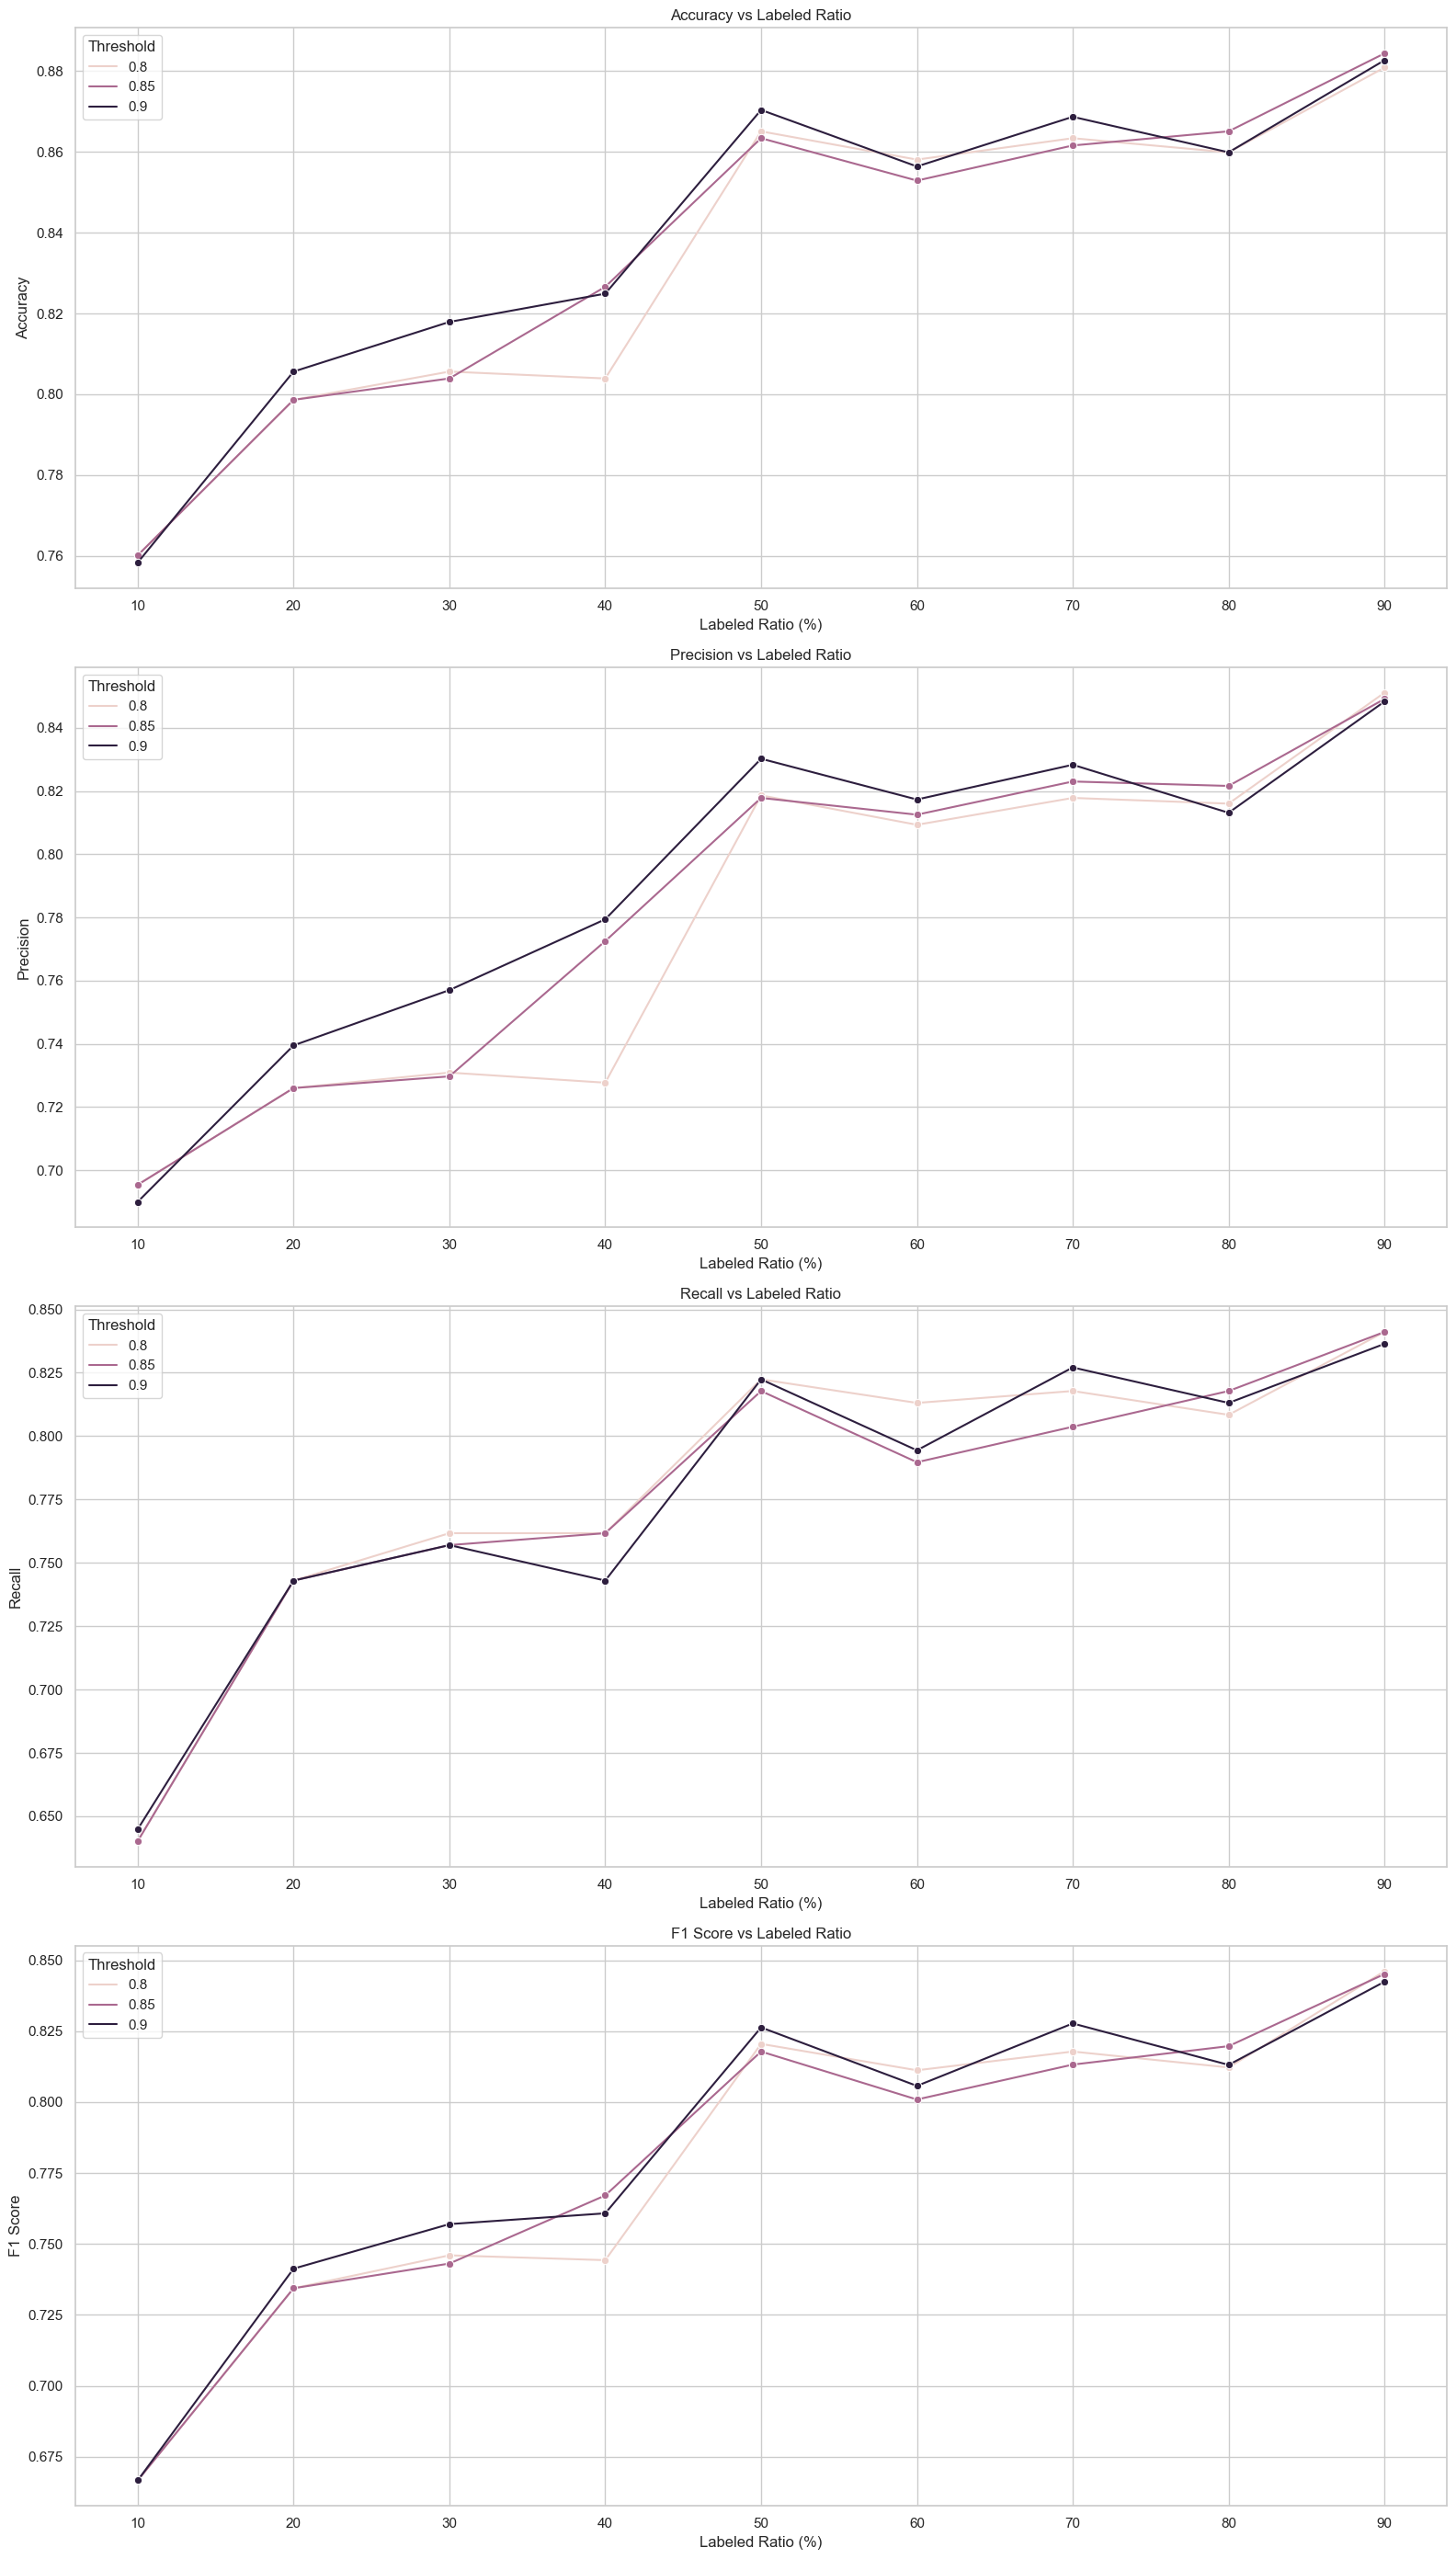

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Paste the result table manually or load from CSV ===
data = [
    ['10%', 0.80, 0.7601, 0.6954, 0.6402, 0.6667],
    ['10%', 0.85, 0.7601, 0.6954, 0.6402, 0.6667],
    ['10%', 0.90, 0.7583, 0.6900, 0.6449, 0.6667],
    ['20%', 0.80, 0.7986, 0.7260, 0.7430, 0.7344],
    ['20%', 0.85, 0.7986, 0.7260, 0.7430, 0.7344],
    ['20%', 0.90, 0.8056, 0.7395, 0.7430, 0.7413],
    ['30%', 0.80, 0.8056, 0.7309, 0.7617, 0.7460],
    ['30%', 0.85, 0.8039, 0.7297, 0.7570, 0.7431],
    ['30%', 0.90, 0.8179, 0.7570, 0.7570, 0.7570],
    ['40%', 0.80, 0.8039, 0.7277, 0.7617, 0.7443],
    ['40%', 0.85, 0.8266, 0.7725, 0.7617, 0.7671],
    ['40%', 0.90, 0.8249, 0.7794, 0.7430, 0.7608],
    ['50%', 0.80, 0.8651, 0.8186, 0.8224, 0.8205],
    ['50%', 0.85, 0.8634, 0.8178, 0.8178, 0.8178],
    ['50%', 0.90, 0.8704, 0.8302, 0.8224, 0.8263],
    ['60%', 0.80, 0.8581, 0.8093, 0.8131, 0.8112],
    ['60%', 0.85, 0.8529, 0.8125, 0.7897, 0.8009],
    ['60%', 0.90, 0.8564, 0.8173, 0.7944, 0.8057],
    ['70%', 0.80, 0.8634, 0.8178, 0.8178, 0.8178],
    ['70%', 0.85, 0.8616, 0.8230, 0.8037, 0.8132],
    ['70%', 0.90, 0.8687, 0.8283, 0.8271, 0.8277],
    ['80%', 0.80, 0.8599, 0.8160, 0.8084, 0.8122],
    ['80%', 0.85, 0.8651, 0.8216, 0.8178, 0.8197],
    ['80%', 0.90, 0.8599, 0.8131, 0.8131, 0.8131],
    ['90%', 0.80, 0.8809, 0.8511, 0.8411, 0.8461],
    ['90%', 0.85, 0.8844, 0.8491, 0.8411, 0.8451],
    ['90%', 0.90, 0.8827, 0.8483, 0.8364, 0.8424],
]

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Labeled Ratio", "Threshold", "Accuracy", "Precision", "Recall", "F1 Score"])
df["Labeled Ratio"] = df["Labeled Ratio"].str.rstrip('%').astype(int)

# Plot
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 1, figsize=(16, 28))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(data=df, x="Labeled Ratio", y=metric, hue="Threshold", marker="o", ax=axes[i])
    axes[i].set_title(f"{metric} vs Labeled Ratio")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Labeled Ratio (%)")
    axes[i].legend(title="Threshold")

plt.tight_layout()
plt.show()


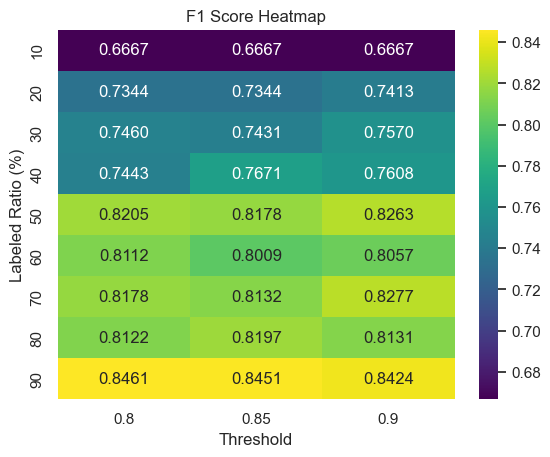

In [14]:
# Example for F1 Score Heatmap
pivot_f1 = df.pivot("Labeled Ratio", "Threshold", "F1 Score")
sns.heatmap(pivot_f1, annot=True, fmt=".4f", cmap="viridis")
plt.title("F1 Score Heatmap")
plt.xlabel("Threshold")
plt.ylabel("Labeled Ratio (%)")
plt.show()


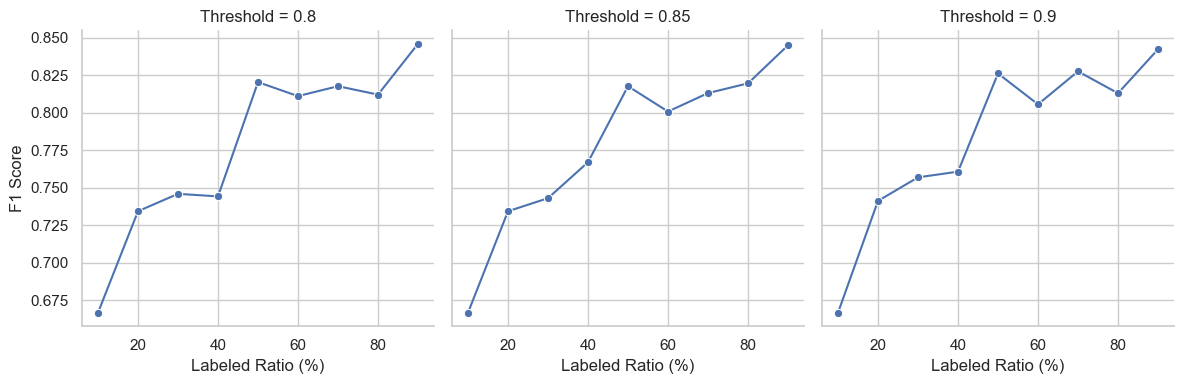

In [15]:
g = sns.FacetGrid(df, col="Threshold", col_wrap=3, height=4)
g.map_dataframe(sns.lineplot, x="Labeled Ratio", y="F1 Score", marker="o")
g.set_titles("Threshold = {col_name}")
g.set_axis_labels("Labeled Ratio (%)", "F1 Score")
plt.tight_layout()
plt.show()


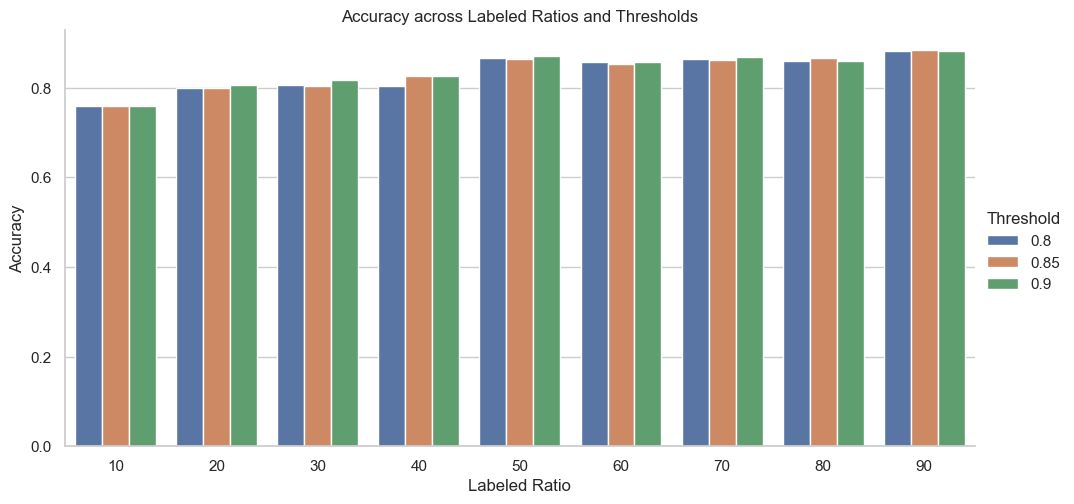

In [16]:
sns.catplot(data=df, x="Labeled Ratio", y="Accuracy", hue="Threshold", kind="bar", height=5, aspect=2)
plt.title("Accuracy across Labeled Ratios and Thresholds")
plt.show()


In [18]:
# Ensure Labeled Ratio is numeric (handle if it's still a string like "90%")
if df["Labeled Ratio"].dtype == object:
    df["Labeled Ratio"] = df["Labeled Ratio"].str.replace("%", "").astype(int)
else:
    df["Labeled Ratio"] = df["Labeled Ratio"].astype(int)


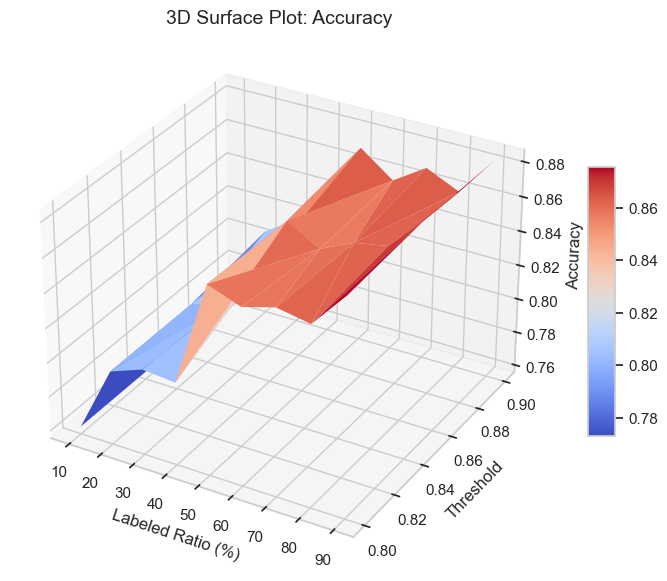

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Fix the column type
if df["Labeled Ratio"].dtype == object:
    df["Labeled Ratio"] = df["Labeled Ratio"].str.replace("%", "").astype(int)
else:
    df["Labeled Ratio"] = df["Labeled Ratio"].astype(int)

X = df["Labeled Ratio"]
Y = df["Threshold"]
Z = df["Accuracy"]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, edgecolor='none')

ax.set_title("3D Surface Plot: Accuracy", fontsize=14)
ax.set_xlabel("Labeled Ratio (%)")
ax.set_ylabel("Threshold")
ax.set_zlabel("Accuracy")

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


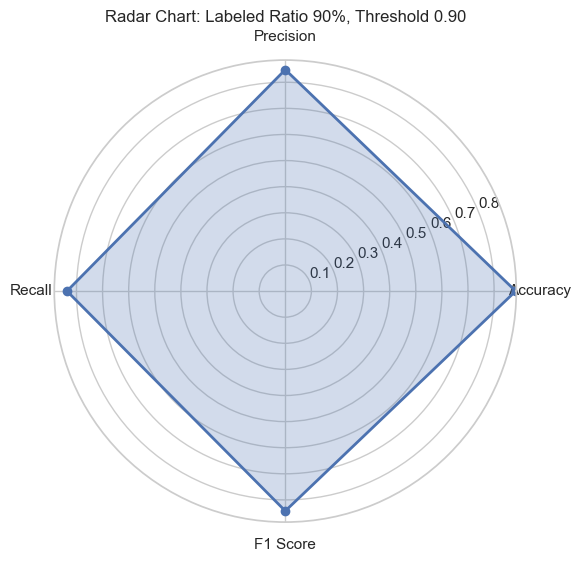

In [21]:
filtered = df[(df["Labeled Ratio"] == 90) & (df["Threshold"] == 0.90)]

if not filtered.empty:
    row = filtered.iloc[0]
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [row[m] for m in metrics]

    # Radar chart
    import matplotlib.pyplot as plt
    import numpy as np

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    values += values[:1]  # repeat first value to close the circle
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title("Radar Chart: Labeled Ratio 90%, Threshold 0.90")
    plt.show()
else:
    print("No matching row found for Labeled Ratio 90% and Threshold 0.90.")
